In [2]:
import time
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D

# from matplotlib import rc
# rc('text', usetex=True)
# rc('text.latex', unicode=True)
# rc('text.latex', preamble=r"\usepackage[utf8]{inputenc}")
# rc('text.latex', preamble=r"\usepackage[russian]{babel}")
# %matplotlib inline

# from itertools import cycle
# rc('lines', linewidth=2.0)
# rc('axes', prop_cycle=(cycler('color', 'bgrcmyk') +
#                        cycler('linestyle', ['-', '--', ':', '-.', '-', '--', ':'])))
# #rc('axes', prop_cycle=(cycler('color', ['k', 'k', 'k', 'k']) +
# #                       cycler('linestyle', ['-', '--', ':', '-.'])))
# rc('figure', figsize=(15.0, 6.0))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

**Kovasznay flow**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq2}
\left\lbrace 
\begin{array}{l}
 u = 1-e^{-\lambda x} \cos(2 \pi y) ,\\
 v = \lambda/{2\pi} e^{\lambda x} \sin(2 \pi y) ,\\
 p = p_0-\frac{1}{2}e^{2\lambda x} ,
\end{array}
\right. 
\end{equation} 
in $[-1.5, 1.5]\times[-2.5, 2]\times[0, ]$, where $\lambda = \mathrm{Re}/2-\sqrt{\mathrm{Re}^2/4+4\pi^2}$.
We have set Reynolds number $\mathrm{Re}=40$, $p_0=1$ and $\tau=0.05h$.

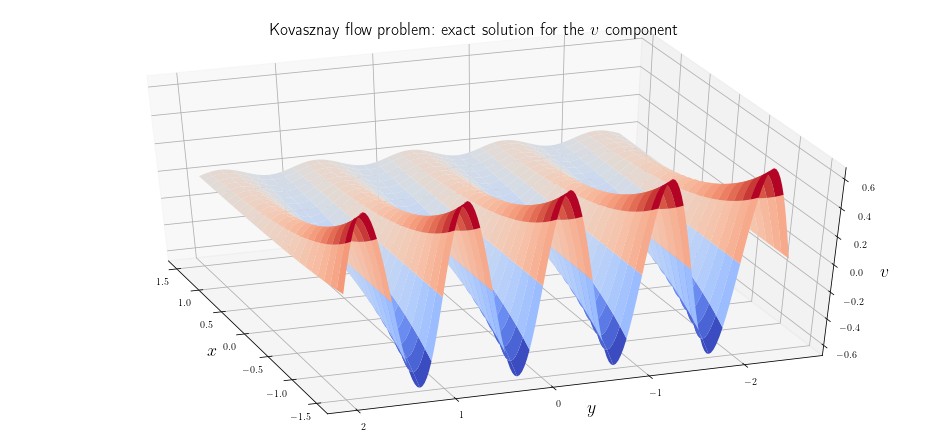

In [3]:
def kovasznay_flow(t, x, y, Re):
    p0 = 1.
    Lambda = Re/2.-sqrt(Re**2/4.+4*pi**2)
    return (1.-exp(Lambda*x)*cos(2.*pi*y),\
            Lambda/(2.*pi)*exp(Lambda*x)*sin(2.*pi*y),\
            p0-1./2*exp(2.*Lambda*x))

h, Re= 2.5e-2, 40.

x, y = meshgrid(arange(-1.5, 1.5, h, dtype=float64),\
                arange(-2.5, 2., h, dtype=float64), indexing='ij')
fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, kovasznay_flow(0., x, y, Re)[1],\
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$v$", {'fontsize': 18})
axes.set_title(r"Kovasznay flow problem: exact solution for the $v$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./kovasznay_flow_exact_v.pdf')
close()

**Taylor decaying**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 
in $[0, 2\pi]\times[0, 2\pi]\times[0, 6]$, where the Reynolds number $\mathrm{Re} = 10^{2}$, 
$\tau=0.05h$.

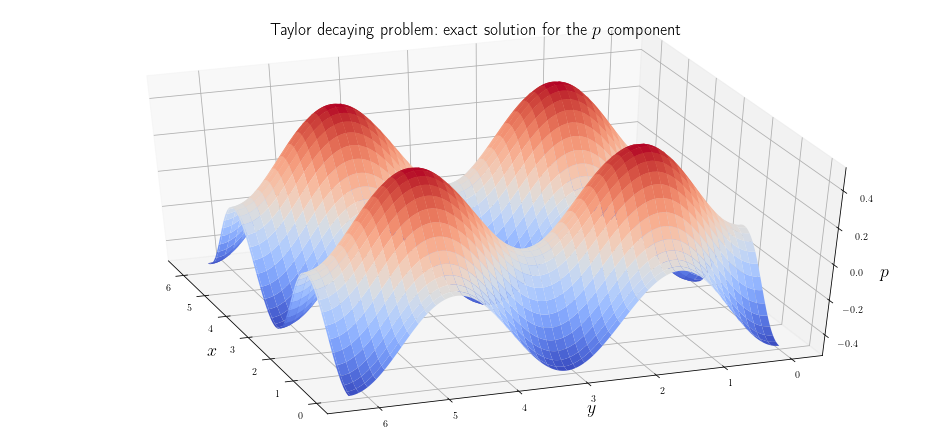

In [4]:
def taylor_decaying(t, x, y, Re):
    return (-exp(-2.*t/Re)*cos(x)*sin(y),
             exp(-2.*t/Re)*sin(x)*cos(y),
            -exp(-4.*t/Re)*(cos(2.*x)+cos(2.*y))/4.)

h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, taylor_decaying(0., x, y, Re)[2], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$p$", {'fontsize': 18})
axes.set_title(r"Taylor decaying problem: exact solution for the $p$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()


In [5]:
def A_1(Nx, Ny):
    Nxy = Nx*Ny
    N = 5*(Nx-2)*(Ny-2)+2*(Nx+Ny-2)

    def jk(j, k):
        return j*Ny+k

    # auxiliary arrays to set the sparse matrix
    row = empty(N, dtype=int32)
    col = empty(N, dtype=int32)
    data = empty(N, dtype=float64)

    l = 0
    #border conditions
    for k in range(Ny):
        p = jk(0, k)
        row[l], col[l], data[l] = p, p, 1.
        l += 1
    for j in range(1, Nx-1):
        #border conditions
        p = jk(j, 0)
        row[l], col[l], data[l] = p, p, 1.
        l += 1
        #main area
        for k in range(1, Ny-1):
            p = jk(j, k)
            row[l:l+5] = p
            col[l:l+5] = jk(j, k-1), jk(j, k+1), p, jk(j-1, k), jk(j+1, k)
            data[l:l+5] = 1., 1., -4., 1., 1.
            l += 5
        #border conditions
        p = jk(j, Ny-1)
        row[l], col[l], data[l] = p, p, 1.
        l += 1
    #border conditions
    for k in range(Ny):
        p = jk(Nx-1, k)
        row[l], col[l], data[l] = p, p, 1.
        l += 1
    assert(l == N)

    A = csr_matrix((data, (row, col)), shape=(Nxy, Nxy))
    return A

def solve_1(A, f, h):
    Nx, Ny = f.shape
    Nxy = Nx*Ny
    # column of free terms
    b = empty(Nxy, dtype=float64)

    b[:Ny] = f[0,:]
    for j in range(1, Nx-1):
        b[j*Ny] = f[j,0]
        b[j*Ny+1:(j+1)*Ny-1] = h**2*f[j,1:-1]
        b[(j+1)*Ny-1] = f[j,-1]
    b[-Ny:] = f[-1,:]

    u = spsolve(A, b)
    #u = lsqr(A, b, atol=1.e-12)[0]
    #u = lsmr(A, b, atol=1.e-12)[0]
    #u, info = gmres(A, b, tol=1.e-12)
    #u, info = lgmres(A, b, tol=1.e-12)
    return u.reshape(Nx,Ny)

In [6]:
def A_2(Nx, Ny):
    Nxy = Nx*Ny
    N = 5*(Nx-4)*(Ny-4)+2*(Nx+Ny-2)+2*(Nx+Ny-6)

    def jk(j, k):
        return j*Ny+k

    # auxiliary arrays to set the sparse matrix
    row = zeros(N, dtype=int32)
    col = zeros(N, dtype=int32)
    data = zeros(N, dtype=float64)

    l = 0
    #border conditions
    for j in [0, 1]:
        for k in range(Ny):
            p = jk(j, k)
            row[l], col[l], data[l] = p, p, 1.
            l += 1
    for j in range(2, Nx-2):
        #border conditions
        for k in [0, 1]:
            p = jk(j, k)
            row[l], col[l], data[l] = p, p, 1.
            l += 1
        #main area
        for k in range(2, Ny-2):
            p = jk(j, k)
            row[l:l+5] = p
            col[l:l+5] = jk(j, k-2), jk(j, k+2), p, jk(j-2, k), jk(j+2, k)
            data[l:l+5] = 1., 1., -4., 1., 1.
            l += 5
        #border conditions
        for k in [Ny-2, Ny-1]:
            p = jk(j, k)
            row[l], col[l], data[l] = p, p, 1.
            l += 1
    #border conditions
    for j in [Nx-2, Nx-1]:
        for k in range(Ny):
            p = jk(j, k)
            row[l], col[l], data[l] = p, p, 1.
            l += 1
    assert(l == N)

    A = csr_matrix((data, (row, col)), shape=(Nxy, Nxy))
    return A

def solve_2(A, f, h):
    Nx, Ny = f.shape
    Nxy = Nx*Ny
    # column of free terms
    b = empty(Nxy, dtype=float64)

    b[:Ny] = f[0,:]
    b[Ny:2*Ny] = f[1,:]
    for j in range(2, Nx-2):
        b[j*Ny:j*Ny+2] = f[j,:2]
        b[j*Ny+2:(j+1)*Ny-2] = (2.*h)**2*f[j,2:-2]
        b[(j+1)*Ny-2:(j+1)*Ny] = f[j,-2:]
    b[-2*Ny:-Ny] = f[-2,:]
    b[-Ny:] = f[-1,:]

    u = spsolve(A, b)
    #u = bicg(A, b, tol=1.e-12, x0=u)[0]
    #u = lsqr(A, b, atol=1.e-12)[0]
    #u = lsmr(A, b, atol=1.e-12)[0]
    #u, info = gmres(A, b, tol=1.e-12)
    #u, info = lgmres(A, b, tol=1.e-12)
    return u.reshape(Nx,Ny)

In [37]:
def error(f, g):
    return max((abs(f-g)/(1.+abs(g))).flat)

def div(u, v, h):
    return norm((u[3:-1,2:-2]-u[1:-3,2:-2])/(2*h)+\
                (v[2:-2,3:-1]-v[2:-2,1:-3])/(2*h))

def sol(args):
    exact, x, y, t1, fda, h, tau, a, s, Re = args
    err = zeros((int(t1/tau) + 2, 5), dtype=float64)
    A = a(x.shape[0], x.shape[1])
    t = 0.
    u, v, p = exact(t, x, y, Re)
    err[0] = t, 0., 0., 0., div(u, v, h)
    for n in range(1, err.shape[0]):
        t += tau
        sol = exact(t, x, y, Re)
        u1, v1, p1 = fda((u, v, p), sol, tau, h, Re)
        p1 = s(A, p1, h)
        u, v, p = u1, v1, p1

        err[n] = t, error(u, sol[0]), error(v, sol[1]), error(p, sol[2]), div(u, v, h)

        if max(err[n, 1:]) > 1.e1:
            break
    return (args, n, err)

**FDA1**

Gerdt Vladimir P., Blinkov Yuri A. Involution and Difference Schemes for the Navier–Stokes Equations. CASC. Lecture Notes in Computer Science, 2009, vol. 5743, pp. 94-105. DOI: 10.1007/978-3-642-04103-7_10 Available at: https://link.springer.com/chapter/10.1007/978-3-642-04103-7_10

Eqs. 13

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + \frac{{u_{j+1,k}^n}^2-{u_{j-1,k}^n}^2}{2h}
+ \frac{v_{j,k+1}^n u_{j,k+1}^n-v_{j,k-1}^nu_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+2,k}^n-2u_{jk}^n+u_{j-2,k}^n}{4h^2} + \frac{u_{j,k+2}^n-2u_{jk}^n+u_{j,k-2}^n}{4h^2}
\right) = 0,\\[0.2cm] %\label{clas_2}
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + \frac{u_{j+1,k}^nv_{j+1,k}^n-u_{j-1,k}^n v_{j-1,k}^n}{2h}
+\frac{{v_{j,k+1}^n}^2-{v_{j,k-1}^n}^2}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+2,k}^n-2v_{jk}^n+v_{j-2,k}^n}{4h^2} + \frac{v_{j,k+2}^n-2v_{jk}^n+v_{j,k-2}^n}{4h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \frac{{u_{j+2,k}^n}^2-2{u_{j,k}^n}^2+{u_{j-2,k}^n}^2}{4h^2} +
\frac{{v_{j,k+2}^n}^2-2{v_{j,k}^n}^2+{v_{j,k-2}^n}^2}{4h^2} \\[0.2cm]
\qquad {} + 2\frac{u_{j+1,k+1}^n v_{j+1,k+1}^n- u_{j+1,k-1}^n v_{j+1,k-1}^n-u_{j-1,k+1}^n v_{j-1,k+1}^n+
u_{j-1,k-1}^n v_{j-1,k-1}^n}{4h^2}\\[0.2cm]
 \qquad {} + \frac{p_{j+2,k}^n-2p_{jk}^n+p_{j-2,k}^n}{4h^2}  + \frac{p_{j,k+2}^n-2p_{jk}^n+p_{j,k-2}^n}{4h^2} = 0\,.
\end{array}
\right.
\end{equation}

In [39]:
def fda1(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/(2.*h)*(\
        u[2:,1:-1]**2-u[:-2,1:-1]**2+\
        v[1:-1,2:]*u[1:-1,2:]-v[1:-1,:-2]*u[1:-1,:-2]+\
        p[2:,1:-1]-p[:-2,1:-1])+tau/(h**2*Re)*(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/(2.*h)*(\
        u[2:,1:-1]*v[2:,1:-1]-u[:-2,1:-1]*v[:-2,1:-1]+\
        v[1:-1,2:]**2-v[1:-1,:-2]**2+\
        p[1:-1,2:]-p[1:-1,:-2])+tau/(h**2*Re)*(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])

    p1[2:-2,2:-2] = -(\
        u1[4:,2:-2]**2-2.*u1[2:-2,2:-2]**2+u1[:-4,2:-2]**2+\
        2.*(u1[3:-1,3:-1]*v1[3:-1,3:-1]-u1[3:-1,1:-3]*v1[3:-1,1:-3]-\
            u1[1:-3,3:-1]*v1[1:-3,3:-1]+u1[1:-3,1:-3]*v1[1:-3,1:-3])+
        v1[2:-2,4:]**2-2.*v1[2:-2,2:-2]**2+v1[2:-2,:-4]**2)/(4.*h**2)
    return u1, v1, p1

**FDA2**

Gerdt Vladimir P., Blinkov Yuri A. Involution and Difference Schemes for the Navier–Stokes Equations. CASC. Lecture Notes in Computer Science, 2009, vol. 5743, pp. 94-105. DOI: 10.1007/978-3-642-04103-7\_10 Available at: https://link.springer.com/chapter/10.1007/978-3-642-04103-7_10

Eqs. 18

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + u_{jk}^n \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + v_{jk}^n \frac{u_{j,k+1}^n-u_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+1,k}^n-2u_{jk}^n+u_{j-1,k}^n}{h^2} + \frac{u_{j,k+1}^n-2u_{jk}^n+u_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm] %\label{clas_2}
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + u_{jk}^n \frac{v_{j+1,k}^n-v_{j-1,k}^n}{2h} + v_{jk}^n \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+1,k}^n-2v_{jk}^n+v_{j-1,k}^n}{h^2} + \frac{v_{j,k+1}^n-2v_{jk}^n+v_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \left(\frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h}\right)^2 + 2\frac{v_{j+1,k}^n-v_{j-1,k}^n}{2h} \frac{u_{j,k+1}^n-u_{j,k-1}^n}{2h}
+  \left(\frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h}\right)^2 \\[0.2cm]
 \qquad {} + \frac{p_{j+1,k}^n-2p_{jk}^n+p_{j-1,k}^n}{h^2}  + \frac{p_{j,k+1}^n-2p_{jk}^n+p_{j,k-1}^n}{h^2} = 0
\end{array}
\right.
\end{equation}

In [40]:
def fda2(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/(2.*h)*(\
        u[1:-1,1:-1]*(u[2:,1:-1]-u[:-2,1:-1])+\
        v[1:-1,1:-1]*(u[1:-1,2:]-u[1:-1,:-2])+\
        p[2:,1:-1]-p[:-2,1:-1])+tau/(h**2*Re)*(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/(2.*h)*(\
        u[1:-1,1:-1]*(v[2:,1:-1]-v[:-2,1:-1])+\
        v[1:-1,1:-1]*(v[1:-1,2:]-v[1:-1,:-2])+\
        p[1:-1,2:]-p[1:-1,:-2])+tau/(h**2*Re)*(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])

    p1[1:-1,1:-1] = -(\
        (u1[2:,1:-1]-u1[:-2,1:-1])**2+\
        2.*(v1[2:,1:-1]-v1[:-2,1:-1])*(u1[1:-1,2:]-u1[1:-1,:-2])+\
        (v1[1:-1,2:]-v1[1:-1,:-2])**2)/(4.*h**2)

    return u1, v1, p1

**FDA3**

Gerdt Vladimir P., Blinkov Yuri A. Involution and Difference Schemes for the Navier–Stokes Equations. CASC. Lecture Notes in Computer Science, 2009, vol. 5743, pp. 94-105. DOI: 10.1007/978-3-642-04103-7\_10 Available at: https://link.springer.com/chapter/10.1007/978-3-642-04103-7_10

Eqs. 15

Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto On Consistency of Finite Difference Approximations to the Navier-Stokes Equations. CASC. Lecture Notes in Computer Science, 2013, vol. 8136, pp. 46-60. DOI: 10.1007/978-3-319-02297-0_4 Available at: https://link.springer.com/chapter/10.1007/978-3-319-02297-0_4

В этой статье FDA2 и FDA3 совпадают, ошибка !!!! FDA3 совместная система


\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + \frac{{u_{j+1,k}^n}^2-{u_{j-1,k}^n}^2}{2h}
+ \frac{v_{j,k+1}^n u_{j,k+1}^n-v_{j,k-1}^nu_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+1,k}^n-2u_{jk}^n+u_{j-1,k}^n}{h^2} + \frac{u_{j,k+1}^n-2u_{jk}^n+u_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm] %\label{clas_2}
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + \frac{u_{j+1,k}^nv_{j+1,k}^n-u_{j-1,k}^n v_{j-1,k}^n}{2h}
+\frac{{v_{j,k+1}^n}^2-{v_{j,k-1}^n}^2}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+1,k}^n-2v_{jk}^n+v_{j-1,k}^n}{h^2} + \frac{v_{j,k+1}^n-2v_{jk}^n+v_{j,k-1}^n}{h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \frac{{u_{j+2,k}^n}^2-2{u_{j,k}^n}^2+{u_{j-2,k}^n}^2}{4h^2} +
\frac{{v_{j,k+2}^n}^2-2{v_{j,k}^n}^2+{v_{j,k-2}^n}^2}{4h^2} \\[0.2cm]
\qquad {} + 2\frac{u_{j+1,k+1}^n v_{j+1,k+1}^n- u_{j+1,k-1}^n v_{j+1,k-1}^n-u_{j-1,k+1}^n v_{j-1,k+1}^n+
u_{j-1,k-1}^n v_{j-1,k-1}^n}{4h^2}\\[0.2cm]
 \qquad {} + \frac{p_{j+2,k}^n-2p_{jk}^n+p_{j-2,k}^n}{4h^2}  + \frac{p_{j,k+2}^n-2p_{jk}^n+p_{j,k-2}^n}{4h^2} = 0\,.
\end{array}
\right.
\end{equation}

In [41]:
def fda3(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/(2.*h)*(\
        u[2:,1:-1]**2-u[:-2,1:-1]**2+\
        v[1:-1,2:]*u[1:-1,2:]-v[1:-1,:-2]*u[1:-1,:-2]+\
        p[2:,1:-1]-p[:-2,1:-1])+tau/(h**2*Re)*(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/(2.*h)*(\
        u[2:,1:-1]*v[2:,1:-1]-u[:-2,1:-1]*v[:-2,1:-1]+\
        v[1:-1,2:]**2-v[1:-1,:-2]**2+\
        p[1:-1,2:]-p[1:-1,:-2])+tau/(h**2*Re)*(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])

    p1[2:-2,2:-2] = -(\
        u1[4:,2:-2]**2-2.*u1[2:-2,2:-2]**2+u1[:-4,2:-2]**2+\
        2.*(u1[3:-1,3:-1]*v1[3:-1,3:-1]-u1[3:-1,1:-3]*v1[3:-1,1:-3]-\
                u1[1:-3,3:-1]*v1[1:-3,3:-1]+u1[1:-3,1:-3]*v1[1:-3,1:-3])+
        v1[2:-2,4:]**2-2.*v1[2:-2,2:-2]**2+v1[2:-2,:-4]**2)/(4.*h**2)

    return u1, v1, p1

**FDA1_corr**


Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 415

\begin{equation}
\left\lbrace
\begin{array}{l}
{e_1}_{j,k}^n := \frac{u_{j+1,k}^n-u_{j-1,k}^n}{2h} + \frac{v_{j,k+1}^n-v_{j,k-1}^n}{2h} = 0, \\[0.2cm]
{e_2}_{j,k}^n := \frac{u_{jk}^{n+1}-u_{jk}^n}{\tau} + \frac{{u_{j+1,k}^n}^2-{u_{j-1,k}^n}^2}{2h}
+ \frac{v_{j,k+1}^n u_{j,k+1}^n-v_{j,k-1}^nu_{j,k-1}^n}{2h} + \frac{p_{j+1,k}^n-p_{j-1,k}^n}{2h} \\[0.2cm]
 \qquad {} - \frac{1}{\mathrm{Re}} \left( \frac{u_{j+2,k}^n-2u_{jk}^n+u_{j-2,k}^n}{4h^2} + \frac{u_{j,k+2}^n-2u_{jk}^n+u_{j,k-2}^n}{4h^2}
\right) = 0,\\[0.2cm] %\label{clas_2}
{e_3}_{j,k}^n :=\frac{v_{jk}^{n+1}-v_{jk}^n}{\tau} + \frac{u_{j+1,k}^nv_{j+1,k}^n-u_{j-1,k}^n v_{j-1,k}^n}{2h}
\frac{{v_{j,k+1}^n}^2-{v_{j,k-1}^n}^2}{2h} +  \frac{p_{j,k+1}^n-p_{j,k-1}^n}{2h} \\[0.2cm]
 \qquad  {} - \frac{1}{\mathrm{Re}} \left( \frac{v_{j+2,k}^n-2v_{jk}^n+v_{j-2,k}^n}{4h^2} + \frac{v_{j,k+2}^n-2v_{jk}^n+v_{j,k-2}^n}{4h^2}
\right) = 0,\\[0.2cm]
{e_4}_{j,k}^n := \frac{{u_{j+2,k}^n}^2-2{u_{j,k}^n}^2+{u_{j-2,k}^n}^2}{4h^2} +
\frac{{v_{j,k+2}^n}^2-2{v_{j,k}^n}^2+{v_{j,k-2}^n}^2}{4h^2} \\[0.2cm]
\qquad {} + 2\frac{u_{j+1,k+1}^n v_{j+1,k+1}^n- u_{j+1,k-1}^n v_{j+1,k-1}^n-u_{j-1,k+1}^n v_{j-1,k+1}^n+
u_{j-1,k-1}^n v_{j-1,k-1}^n}{4h^2}\\[0.2cm]
 \qquad {} + \frac{p_{j+2,k}^n-2p_{jk}^n+p_{j-2,k}^n}{4h^2}  + \frac{p_{j,k+2}^n-2p_{jk}^n+p_{j,k-2}^n}{4h^2} 
\\[0.2cm] 
\qquad {} + \frac{2}{\mathrm{Re}}\frac{-u_{j+2,k}^n + 4u_{j+1,k}^n -4u_{j-1,k}^n + u_{j-2,k}^n
- u_{j+1,k+1}^n - u_{j+1,k-1}^n + u_{j-1,k+1}^n + u_{j-1,k-1}^n}{4h^3}
\\[0.2cm] 
\qquad {} + \frac{2}{\mathrm{Re}}\frac{-v_{j,k+2}^n + 4v_{j,k+1}^n - 4v_{j,k-1}^n + v_{j,k-1}^n
- v_{j+1,k+1}^n - v_{j-1,k+1}^n + v_{j+1,k-1}^n + v_{j-1,k-1}^n}{4h^3}
= 0\,.
\end{array}
\right.
\end{equation}

In [46]:
def fda1_corr(sol, exact, tau, h, Re):
    u, v, p = sol
    u1, v1, p1 = copy(exact)

    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/(2.*h)*(\
        u[2:,1:-1]**2-u[:-2,1:-1]**2+\
        v[1:-1,2:]*u[1:-1,2:]-v[1:-1,:-2]*u[1:-1,:-2]+\
        p[2:,1:-1]-p[:-2,1:-1])+tau/(h**2*Re)*(\
        u[2:,1:-1]+u[:-2,1:-1]+u[1:-1,2:]+u[1:-1,:-2]-4.*u[1:-1,1:-1])

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/(2.*h)*(\
        u[2:,1:-1]*v[2:,1:-1]-u[:-2,1:-1]*v[:-2,1:-1]+\
        v[1:-1,2:]**2-v[1:-1,:-2]**2+\
        p[1:-1,2:]-p[1:-1,:-2])+tau/(h**2*Re)*(\
        v[2:,1:-1]+v[:-2,1:-1]+v[1:-1,2:]+v[1:-1,:-2]-4.*v[1:-1,1:-1])

    p1[2:-2,2:-2] = -(\
        u1[4:,2:-2]**2-2.*u1[2:-2,2:-2]**2+u1[:-4,2:-2]**2+\
        2.*(u1[3:-1,3:-1]*v1[3:-1,3:-1]-u1[3:-1,1:-3]*v1[3:-1,1:-3]-\
            u1[1:-3,3:-1]*v1[1:-3,3:-1]+u1[1:-3,1:-3]*v1[1:-3,1:-3])+
        v1[2:-2,4:]**2-2.*v1[2:-2,2:-2]**2+v1[2:-2,:-4]**2+\
        2./(h*Re)*(-u1[4:,2:-2]+4.*u1[3:-1,2:-2]-4.*u1[1:-3,2:-2]+u1[:-4,2:-2]-\
                u1[3:-1,3:-1]-u1[3:-1,1:-3]+u1[1:-3,3:-1]+u1[1:-3,1:-3])+
        2./(h*Re)*(-v1[2:-2,4:]+4.*v1[2:-2,3:-1]-4.*v1[2:-2,1:-3]+v1[2:-2,:-4]-\
                v1[3:-1,3:-1]-v1[1:-3,3:-1]+v1[3:-1,1:-3]+v1[1:-3,1:-3]))/(4.*h**2)
    return u1, v1, p1

In [ ]:
fda = (\
(fda1, A_2, solve_2),\
(fda2, A_1, solve_1),\
(fda3, A_2, solve_2),\
(fda1_corr, A_2, solve_2),\
)

# Taylor decaying

In [58]:
tasks, n = [], 51
for m in range(5, n):
    h = pi/(m+1)
    tau = 0.05*h
    x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                    arange(0., 2.*pi, h, dtype=float64), indexing='ij')

    for f, a, s in fda:
        args = taylor_decaying, x, y, 1.0, f, h, tau, a, s, 100.
        tasks.append(args)
len(tasks)

24

In [59]:
proc = 6
clock = time.perf_counter()
pool = Pool(processes=proc)
res = pool.map_async(sol, tasks)
pool.close()
pool.join()
result = res.get()
print("Time: %.3f * %d" % (time.perf_counter() - clock, proc))
len(result)

Time: 0.727


24

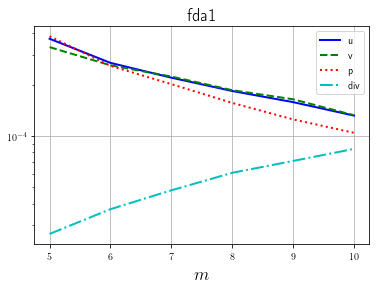

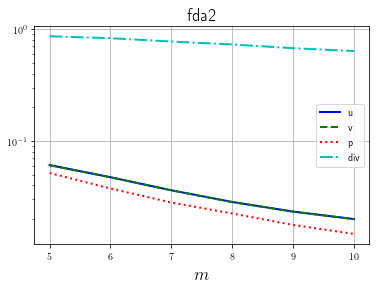

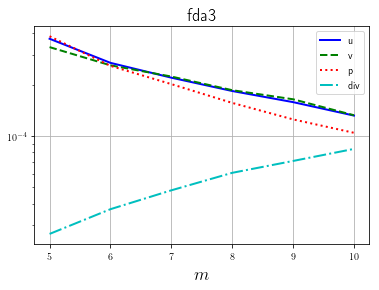

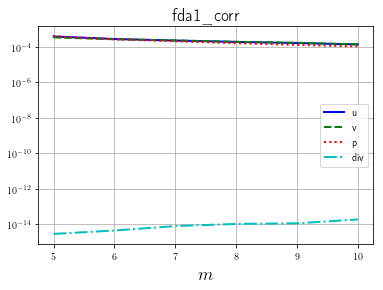

In [63]:
l = ['u', 'v', 'p', 'div']
for f, a, s in fda:
    res = sorted((r for r in result if r[0][4] == f), key=lambda r: r[1])
    title(str(f).split(' ')[1].replace('_', '\_'), {'fontsize': 18})
    for k in range(4):
        semilogy(list(range(5, n)),\
             [r[2][r[1]][k+1] for r in res],\
             label=l[k])
    xlabel(r'$m$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='best', fancybox=True)
    show()
    close()

# Kovasznay flow

In [69]:
tasks, n = [], 71
for m in range(60, n):
    h = 3.0/(m+1)
    tau = 0.05*h
    x, y = meshgrid(arange(-1.5, 1.5, h, dtype=float64),\
                    arange(-2.5, 2.0, h, dtype=float64), indexing='ij')    

    for f, a, s in fda:
        args = kovasznay_flow, x, y, 1.0, f, h, tau, a, s, 40.
        tasks.append(args)
len(tasks)

44

In [70]:
proc = 3
clock = time.perf_counter()
pool = Pool(processes=proc)
res = pool.map_async(sol, tasks)
pool.close()
pool.join()
result = res.get()
print("Time: %.3f * %d" % (time.perf_counter() - clock, proc))
len(result)

Time: 163.731 * 3


44

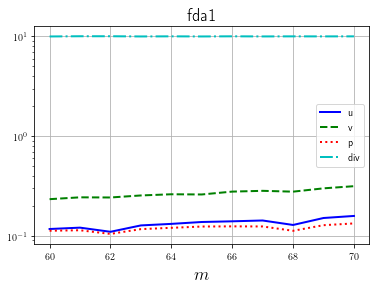

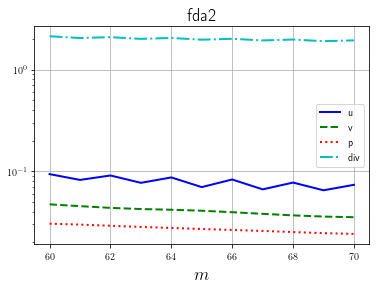

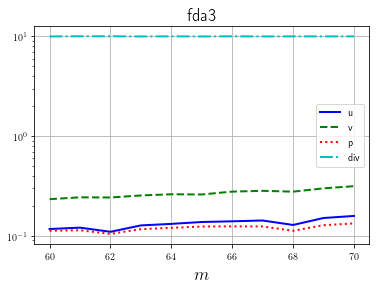

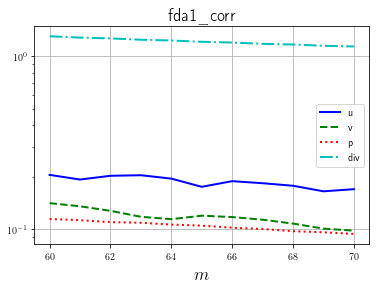

In [71]:
l = ['u', 'v', 'p', 'div']
for f, a, s in fda:
    res = sorted((r for r in result if r[0][4] == f), key=lambda r: r[1])
    title(str(f).split(' ')[1].replace('_', '\_'), {'fontsize': 18})
    for k in range(4):
        semilogy(list(range(60, n)),\
             [r[2][r[1]][k+1] for r in res],\
             label=l[k])
    xlabel(r'$m$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='best', fancybox=True)
    show()
    close()

In [ ]:
def tbl(exact, res):
    print(r"""\begin{center}
%s\\
\begin{tabular}{rrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{$\left\|u-u_{ext}\right\|$} &
\multicolumn{1}{c}{$\left\|v-v_{ext}\right\|$} &
\multicolumn{1}{c}{$\left\|p-p_{ext}\right\|$} \\""" % exact)
    for l in res:
        fda, r = l
        print(r"  \hline \multicolumn{5}{c}{%s} \\" % fda)
        for h, n, err in r:
            print(r'  {:.1e} & {:.2f} & {:.2e} & {:.2e} & {:.2e} \\'.format(h, *err[n-1,:]))
    print(r"""\hline
\end{tabular}
\end{center}
""")

tbl("Taylor decaying problem", res1)

tbl(" Kovasznay flow problem", res1)